<a href="https://colab.research.google.com/github/AndreassOlsson/drone-anomalydetection/blob/main/UMCD_DataLoader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import bisect
import tarfile
import pickle
from glob import glob

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn # nn.BCELoss
import torch.optim as optimizer
import torch.nn.functional as F 
import torch.utils.data as data # data.DataLoader, data.Dataset
import torchvision.transforms as transforms # ToTensor
from tqdm import tqdm


np.random.seed(42)
torch.manual_seed(42)
%matplotlib inline
plt.style.use('ggplot')

# Data

In [2]:
tarfile.open(r'/content/drive/MyDrive/Andreas Olsson/Public-Safety/data/UMCD/umcd-extracted.tgz', 'r:gz').extractall()

## Inspect a video

In [ ]:
def display_frames(video_path=None, cv2_videocapture=None, n_frames=10, starting_frame=0, interval=30, n_cols=5):
  """
  If cv2_videocapture is provided, it overwrites the video_path
  """
  cap = cv2.VideoCapture(video_path) if not cv2_videocapture else cv2_videocapture
  n_frames_total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  frames = [starting_frame + interval * i for i in range(n_frames) if starting_frame + interval * i <= n_frames_total]
  n_frames = len(frames)

  n_rows = bisect.bisect_right([i for i in range(n_frames) if i % n_cols == 0], n_frames)
  fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3))
  axs = axs.flatten()

  for i, frame in enumerate(frames):
      cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
      res, img = cap.read()
      if res:
          axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
          axs[i].set_title(f'Frame: {frame}')
          axs[i].axis('off')

  plt.tight_layout()
  plt.show()
  cap.release()

def inspect_video(video_path=None, cv2_videocapture=None, df=True, n_frames=10, starting_frame=0, interval=30, n_cols=5):
  cap = cv2.VideoCapture(video_path) if not cv2_videocapture else cv2_videocapture
  fs = cap.get(cv2.CAP_PROP_FRAME_COUNT)
  fps = cap.get(cv2.CAP_PROP_FPS)
  height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
  width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
  print(f'Videospecs:\nFrames {fs}, FPS {fps}, Height {height}, Width {width}')
  print(f'Shape of np array: {cap.read(0)[1].shape}\n')
  if df: display_frames(cv2_videocapture=cap, n_frames=n_frames, starting_frame=starting_frame, interval=interval, n_cols=n_cols)
  else: cap.release()

Videospecs:
Frames 400.0, FPS 49.967, Height 1080.0, Width 1920.0
Shape of np array: (1080, 1920, 3)



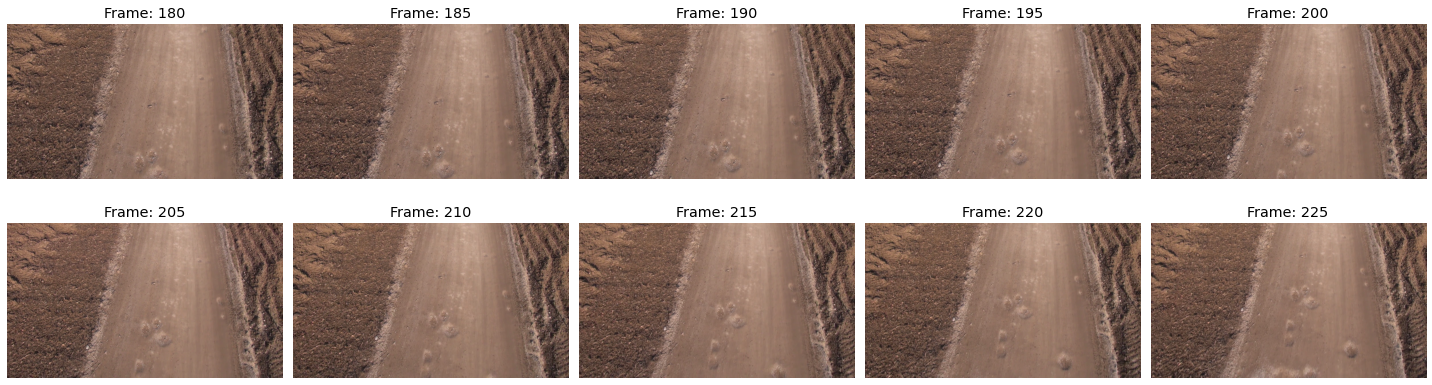

Videospecs:
Frames 799.0, FPS 49.924, Height 1080.0, Width 1920.0
Shape of np array: (1080, 1920, 3)



In [ ]:
inspect_video('/content/umcd-extracted/Normal/Dirt-18-nt.mp4', df=True, starting_frame=180, interval=5)
inspect_video('/content/umcd-extracted/Normal/Dirt-15-nt.mp4', df=False, starting_frame=180, interval=5)

## Create UMCD DataLoaders

In [3]:
class UMCD_video_dset(data.Dataset):
  def __init__(self, video_folder, tfms, target_chw=(3,256,256), n_input_frames=6, n_pred_frames=1):
    self.video_paths = glob(os.path.join(video_folder, '*.mp4'))
    self.tfms, self.target_chw = tfms, target_chw

    self.n_input_frames = n_input_frames
    self.n_pred_frames = n_pred_frames
    self.n = self.n_input_frames + self.n_pred_frames

    self.setup()


  def setup(self):
    frame_intervals = []
    for video_path in self.video_paths:
      cap = cv2.VideoCapture(video_path)
      fs = cap.get(cv2.CAP_PROP_FRAME_COUNT)
      fs = int((fs // self.n) * self.n)

      if len(frame_intervals) == 0: frame_intervals = [fs // self.n]
      else: frame_intervals.append(frame_intervals[-1] + fs // self.n)
      cap.release()

    self.frame_intervals = frame_intervals
    

  def __getitem__(self, batch_idx):
    frame_idxs = list(map(lambda x: x + batch_idx * self.n, range(self.n)))
    video_idx = bisect.bisect_right(self.frame_intervals, batch_idx)
    all_frames = torch.empty(self.n, self.target_chw[0], self.target_chw[1], self.target_chw[2])
    
    cap = cv2.VideoCapture(self.video_paths[video_idx])
    for i, frame_idx in enumerate(frame_idxs):
      tup = cap.read(frame_idx)
      assert tup[0] is not None, 'Failed to extract videoframe from videocapture'
      tfmd_frame = self.tfms(tup[1])
      all_frames[i] = tfmd_frame
    cap.release()

    input_frames, target_frames = all_frames[:self.n_input_frames], all_frames[self.n_input_frames:]
    return (input_frames, target_frames)


  def __len__(self): 
    return self.frame_intervals[-1]


  def show(self, batch_idx=None):
    batch_idx = batch_idx if batch_idx else random.randint(0, self.frame_intervals[-1])
    tup = self.__getitem__(batch_idx)
    input_frames, target_frames = tup[0].numpy(), tup[1].numpy()

    f, axs = plt.subplots(1, self.n, figsize=(self.n*3, 3))

    for i, img in enumerate(input_frames): 
      axs[i].imshow(cv2.cvtColor(img.transpose(1,2,0), cv2.COLOR_BGR2RGB))
      axs[i].set_title(f'Input frame {i+1}')
      axs[i].axis('off')

    for n, img in enumerate(target_frames): 
      i = n + self.n_input_frames
      axs[i].imshow(cv2.cvtColor(img.transpose(1,2,0), cv2.COLOR_BGR2RGB))
      axs[i].set_title(f'Target frame {n+1}')
      axs[i].axis('off')

    plt.tight_layout()
    plt.show()

------------------------------ Dataset succesfully created from video folder /content/umcd-extracted/Normal with length 4617 ------------------------------ 
dset[idx] returns a tuple with two tensors that have the shapes torch.Size([6, 3, 256, 256]) and torch.Size([1, 3, 256, 256]) --> (input_frames, target_frames)

idx stands for a sort of batch index where the same video yields multiple batches of videos with a fixed length. The frames of one batch never overlap into another batch
and therefor we will use torch´s random split for train and test sets!



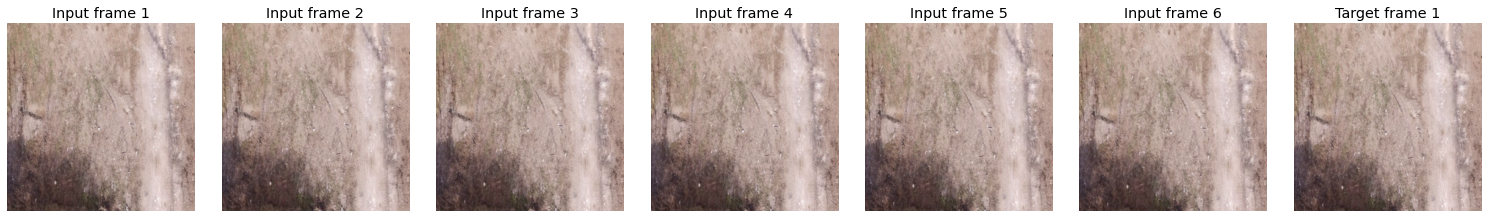

In [4]:
# The training will be on "normal" videos
video_folder = '/content/umcd-extracted/Normal'

# np images are in shape h, w, c
# torch wants images of shape c, h, w
# We need to transform the np arrays to PILImages, then to Tensor etc.
target_chw=(3,256,256)
tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((target_chw[1], target_chw[2])),
    transforms.ToTensor(),
    ])

n_input_frames, n_pred_frames = 6, 1

dset = UMCD_video_dset(video_folder, tfms=tfms, target_chw=target_chw, n_input_frames=n_input_frames, n_pred_frames=n_pred_frames)

idx = random.randint(0, (len(dset)-1))
print('-'*30, f'Dataset succesfully created from video folder {video_folder} with length {len(dset)}', '-'*30, f'\ndset[idx] returns a tuple with two tensors that have the shapes {dset[idx][0].shape} and {dset[idx][1].shape} --> (input_frames, target_frames)\n')
print('idx stands for a sort of batch index where the same video yields multiple batches of videos with a fixed length. The frames of one batch never overlap into another batch\nand therefor we will use torch´s random split for train and test sets!\n')
dset.show()

In [5]:
train_dset, test_dset, rest = data.random_split(dset, [0.4, 0.1, 0.5], generator=torch.Generator().manual_seed(42))

train_dl = data.DataLoader(train_dset, batch_size = 128, shuffle = True)
test_dl = data.DataLoader(test_dset, batch_size = 128, shuffle = True)

In [6]:
len(train_dl.dataset), len(test_dl.dataset)

(1847, 462)

# Model

In [7]:
class SpatioTemporal_AE(nn.Module):
  def __init__(self, encoder, decoder):
    super(SpatioTemporal_AE, self).__init__()
    
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, videos):
    encoded_input = self.encoder(videos)
    decoded_output = self.decoder(encoded_input)
    return decoded_output

## Encoder

The encoder will take as input:
1. The sequence of tubelets (patches) mapped into tubelet embeddings via a linear projection
 1. Tubelets = *x_k*
 2. Weights of trainable linear projection = *E* 
2. An extra learnable embedding prepended to the sequence of tubelet embeddings
 1. Learnable embedding = *x_cls*
3. Learnable spatiotemporal embeddings added to the tubelet embeddings
 1. Learnable spatiotemporal position embeddings = *E_pos*

Encoder input = [*x_cls*; *x_k_1* * *E*; *x_k_2* * *E*; ... ; *x_k_N* * *E*] + E_pos

In [8]:
# PyTorch requires images to be in N C H W format
# Apperently this method with nested for loops was faster than nested list comprehensions
def patchify(batch, patch_thw=(3,16,16)):
  N, T, C, H, W = batch.shape
  t, h, w = patch_thw

  assert T % t == 0, 'Number of videoframes is not divisible by the number of frames in each patch'
  assert H % h == 0, 'Videoframe height is not divisible by patch height'
  assert W % w == 0, 'Videoframe width is not divisible by patch width'

  patches = []
  for video in batch:
    video_patches = []
    for f in range(T//t):
      for y in range(H//h):
        for x in range(W//w):
          video_patches.append(video[f*t:(f+1)*t, :, y*h:(y+1)*h, x*w:(x+1)*w].flatten())
          # print(f'Patch {len(patches)}:\t Video {i}\t Frames {f*t}:{(f+1)*t}\t Channels :\t Rows {y*h}:{(y+1)*h}\t Columns {x*w}:{(x+1)*w}')
    
    patches.append(torch.stack(tuple(video_patches)))
  return torch.stack(tuple(patches))


# Test function
sample_batch = torch.rand(7,6,3,256,256)
N, T, C, H, W = sample_batch.shape 
t, h, w = 3, 16, 16

patches = patchify(sample_batch, patch_thw=(t,h,w))

assert patches.shape == (N, (H/h * W/w) * (T/t), t*C*h*w)

patches.shape

torch.Size([7, 512, 2304])

In [9]:
"Multi-head Self Attention"
class Linear(nn.Module):
  def __init__(self, input_dim=(768,), output_dim=(6, 768//6)):
    super(Linear, self).__init__()

    self.weight = nn.Parameter(torch.randn(*input_dim, *output_dim))
    self.bias = nn.Parameter(torch.randn(*output_dim))

  def forward(self, x, dims):
    return torch.tensordot(x, self.weight, dims=dims) + self.bias


class Multihead_Self_Attention(nn.Module):
  def __init__(self, input_dim=768, n_attention_heads=6):
    super(Multihead_Self_Attention, self).__init__()

    self.input_dim, self.n_attention_heads = input_dim, n_attention_heads

    assert input_dim % n_attention_heads == 0, f'Input dimension is not divisible by number of attention heads'
    
    self.head_dim = input_dim // n_attention_heads

    self.query = Linear(input_dim=(input_dim,), output_dim=(n_attention_heads, self.head_dim))
    self.key = Linear(input_dim=(input_dim,), output_dim=(n_attention_heads, self.head_dim))
    self.value = Linear(input_dim=(input_dim,), output_dim=(n_attention_heads, self.head_dim))
    self.out = Linear(input_dim=(n_attention_heads, self.head_dim), output_dim=(input_dim,))
    
  def forward(self, x):
    # (N, n_embeddings, embedding_dim) --> (N, n_embeddings, n_attention_heads, head_dim) --> (N, n_embeddings, embedding_dim)

    query = self.query(x, dims=([2], [0])).permute(0, 2, 1, 3)
    key = self.key(x, dims=([2], [0])).permute(0, 2, 1, 3)
    value = self.value(x, dims=([2], [0])).permute(0, 2, 1, 3)

    attn_weights = torch.matmul(query, key.transpose(-2,-1)) / self.head_dim ** 0.5
    attn_weights = F.softmax(attn_weights, dim=-1)

    out = torch.matmul(attn_weights, value).permute(0, 2, 1, 3)

    return self.out(out, dims=([2,3],[0,1]))

Multihead_Self_Attention()(torch.randn(7, 99, 768)).shape

torch.Size([7, 99, 768])

In [10]:
class VisionTransformer_block(nn.Module):
  def __init__(self, input_dim=768, mlp_dim=4096, n_attention_heads=6):
    super(VisionTransformer_block, self).__init__()

    self.norm1 = nn.LayerNorm(input_dim)
    self.attention = Multihead_Self_Attention(input_dim, n_attention_heads)
    self.dropout = nn.Dropout(0.1)
    self.norm2 = nn.LayerNorm(input_dim)
    self.mlp = nn.Sequential(
        nn.Linear(input_dim, mlp_dim),
        nn.GELU(),
        nn.Linear(mlp_dim, input_dim)
    )

  def forward(self, x):
    residual = x
    out = self.norm1(x)
    out = self.attention(x)
    out = self.dropout(out)
    out = out + residual

    residual = out
    out = self.norm2(out)
    out = self.mlp(out)
    out = out + residual

    return out

VisionTransformer_block()(torch.randn(7, 99, 768)).shape

torch.Size([7, 99, 768])

In [11]:
class SpatioTemporal_Encoder(nn.Module):
  def __init__(self, video_dim=(6, 3, 256, 256), patch_dim=(3, 16, 16), embedding_dim=768, mlp_dim=1024, n_attention_heads=2, n_transformer_layers=2):
    super(SpatioTemporal_Encoder, self).__init__()

    self.video_dim, self.patch_dim = video_dim, patch_dim
    self.embedding_dim, self.mlp_dim = embedding_dim, mlp_dim
    self.n_attention_heads, self.n_transformer_layers = n_attention_heads, n_transformer_layers

    assert embedding_dim % n_attention_heads == 0, 'Embedding dimension is not divisible by number of attention heads in the transformer'

    T, C, H, W = self.video_dim
    t, h, w = self.patch_dim
    self.n_patches = (H//h * W//w) * (T//t)

    assert T % t == 0, 'Number of videoframes is not divisible by the number of frames in each patch'
    assert H % h == 0, 'Videoframe height is not divisible by patch height'
    assert W % w == 0, 'Videoframe width is not divisible by patch width'

    self.dropout = nn.Dropout(0.1)

    # 1) Linear projection, tubelets = xk_n, weights = E
    self.input_dim = int(t * C * h * w)
    self.linear_projection = nn.Linear(self.input_dim, self.embedding_dim)

    # 2) Extra learnable embedding, x_cls
    self.extra_learnable_embedding = nn.Parameter(torch.zeros(1, 1, self.embedding_dim))

    # 3) Learnable spatiotemporal embedding, E_pos
    self.spatiotemporal_embedding = nn.Parameter(torch.randn(1, (H//h * W//w) * (T//t) + 1, self.embedding_dim))

    # 4) Transformer
    self.transformer_layers = nn.ModuleList([VisionTransformer_block(self.embedding_dim, self.mlp_dim, self.n_attention_heads) for _ in range(self.n_transformer_layers)])
    self.norm = nn.LayerNorm(self.embedding_dim)


    # 5) Map extra learnable embedding to output dim
    # self.output = nn.Linear(((H//h * W//w) * (T//t) + 1) * self.embedding_dim, out_dim) 
    # self.output = nn.Linear(embedding_dim, out_dim) 


    
  def forward(self, videos):
    N, T, C, H, W = videos.shape
    t, h, w = self.patch_dim

    tubelets = patchify(batch=videos, patch_thw=(t,h,w)) 
    tubelet_embeddings = self.linear_projection(tubelets)
    tubelet_embeddings = self.dropout(tubelet_embeddings)
  
    extra_embedding = self.extra_learnable_embedding.repeat(N, 1, 1)
    extra_embedding = self.dropout(extra_embedding)

    embeddings = torch.cat([extra_embedding, tubelet_embeddings], dim=1)
    out = embeddings + self.spatiotemporal_embedding

    for transformer_layer in self.transformer_layers:
      out = transformer_layer(out)
 
    # out = out.view(N, ((H//h * W//w) * (T//t) + 1) * self.embedding_dim) # v2
    # out  = self.output(out)
    # out = self.dropout(out)

    out = out[:,0]
    out = self.norm(out)

    return out

out = SpatioTemporal_Encoder()(torch.randn(7, 6, 3, 256, 256)); out.shape

torch.Size([7, 768])

## Decoder

In [12]:
class SpatioTemporal_Decoder(nn.Module):
  def __init__(self, embedding_dim=768, must_match=(8,8)):
    super(SpatioTemporal_Decoder, self).__init__()

    self.input_channels = embedding_dim // (must_match[0] * must_match[1])
    self.must_match = must_match

    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(self.input_channels, 64, kernel_size=2, stride=2, padding=0),
      nn.BatchNorm2d(64),
      nn.ReLU(),

      nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2, padding=0),
      nn.BatchNorm2d(128),
      nn.ReLU(),

      nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0),
      nn.BatchNorm2d(64),
      nn.ReLU(),

      nn.ConvTranspose2d(64, 16, kernel_size=2, stride=2, padding=0),
      nn.BatchNorm2d(16),
      nn.ReLU(),

      nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2, padding=0),
      nn.Sigmoid(),
    )
    
  def forward(self, x):
    out = x.view(x.size(0), self.input_channels, self.must_match[0], self.must_match[1]) # (N, n_pred_frames 3, 16, 16) for input shape (N, 768)
    out = self.decoder(out).unsqueeze(1)
    return out

SpatioTemporal_Decoder(embedding_dim=768)(torch.rand(7, 768)).shape

torch.Size([7, 1, 3, 256, 256])

# Train model

In [247]:
# TRAIN FUNCTION
model_name = 'UMCD_v1.pth'
state_dict_path = '/content/drive/MyDrive/Andreas Olsson/Public-Safety/models/' + model_name
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Model name: {model_name}, Using device {device}')

def train_epochs(epochs=5, previous_min=np.inf):
  print(f'{"-"*20}Training model {model_name} for {epochs} epochs with {trainable_params:_} trainable params and learning rate of {lr}{"-"*20}\n')
  min_test_loss = previous_min
  for epoch in range(epochs):
    train_epoch_loss = 0.
    model.train()
    for batch in tqdm(train_dl, desc=f'Training Epoch: [{epoch + 1} ---> {epochs}]', position=0, leave=True):
      x, y = batch
      x, y = x.to(device), y.to(device)
      y_hat = model(x)

      train_loss = criterion(y_hat, y)
      train_epoch_loss += train_loss.detach().cpu().item() / len(train_dl)

      optim.zero_grad()
      train_loss.backward()
      optim.step()

    with torch.no_grad():
      test_epoch_loss = 0
      model.eval()
      for batch in tqdm(test_dl, desc=f'Testing Epoch [{epoch + 1} ---> {epochs}]', position=0, leave=True):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)

        test_loss = criterion(y_hat, y)
        test_epoch_loss += test_loss.detach().cpu().item() / len(test_dl)

      print(f'[Epoch {epoch + 1}]\tTrain loss: {train_epoch_loss:.4f}\tTest loss {test_epoch_loss:.4f}')

      if test_epoch_loss < min_test_loss:
        print(f'Test loss decreased ({min_test_loss:.4f}--->{test_epoch_loss:.4f})\tSaving the model...\n')
        min_test_loss = test_epoch_loss
        torch.save(model.state_dict(), state_dict_path)
      else: print('')

Model name: UMCD_v1.pth, Using device cuda


## Initializing model

In [231]:
def get_valid_embedding_dims(n_max=2000, n_attention_heads=None, must_match=(8,8)):
  n_attention_heads = [n_attention_heads] if n_attention_heads else list(range(1,10))  
  return {n: [i for i in range(1, n_max + 1) if i % n == 0 and (1 / (must_match[0] * must_match[1] / i)) % 1 == 0] for n in n_attention_heads}

for k,v in get_valid_embedding_dims().items(): print('n_heads:',k,v)

n_heads: 1 [64, 128, 192, 256, 320, 384, 448, 512, 576, 640, 704, 768, 832, 896, 960, 1024, 1088, 1152, 1216, 1280, 1344, 1408, 1472, 1536, 1600, 1664, 1728, 1792, 1856, 1920, 1984]
n_heads: 2 [64, 128, 192, 256, 320, 384, 448, 512, 576, 640, 704, 768, 832, 896, 960, 1024, 1088, 1152, 1216, 1280, 1344, 1408, 1472, 1536, 1600, 1664, 1728, 1792, 1856, 1920, 1984]
n_heads: 3 [192, 384, 576, 768, 960, 1152, 1344, 1536, 1728, 1920]
n_heads: 4 [64, 128, 192, 256, 320, 384, 448, 512, 576, 640, 704, 768, 832, 896, 960, 1024, 1088, 1152, 1216, 1280, 1344, 1408, 1472, 1536, 1600, 1664, 1728, 1792, 1856, 1920, 1984]
n_heads: 5 [320, 640, 960, 1280, 1600, 1920]
n_heads: 6 [192, 384, 576, 768, 960, 1152, 1344, 1536, 1728, 1920]
n_heads: 7 [448, 896, 1344, 1792]
n_heads: 8 [64, 128, 192, 256, 320, 384, 448, 512, 576, 640, 704, 768, 832, 896, 960, 1024, 1088, 1152, 1216, 1280, 1344, 1408, 1472, 1536, 1600, 1664, 1728, 1792, 1856, 1920, 1984]
n_heads: 9 [576, 1152, 1728]


v1
* embed_dim = 512, mlp_dim = 1024, patch_dim = (3, 16, 16), n_heads = 2, n_layers = 2
* BCELoss of 0.6922 (stuck on predicting the color brown)
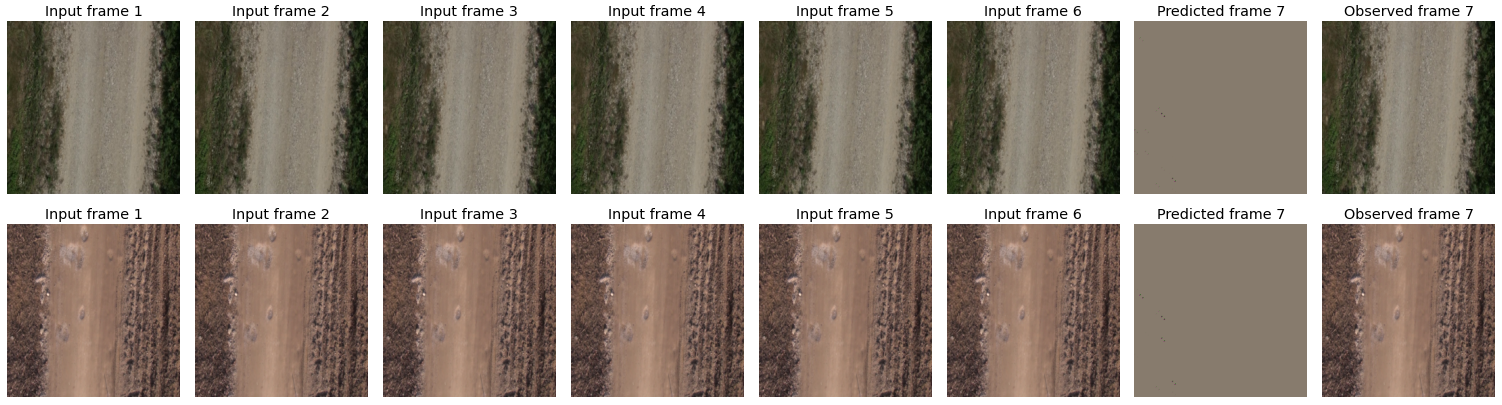

v2
* embed_dim = 64, mlp_dim = 256, patch_dim = (3, 16, 16), n_heads = 2, n_layers = 1, must_match = (8, 8)
* BCELoss of 0.6786
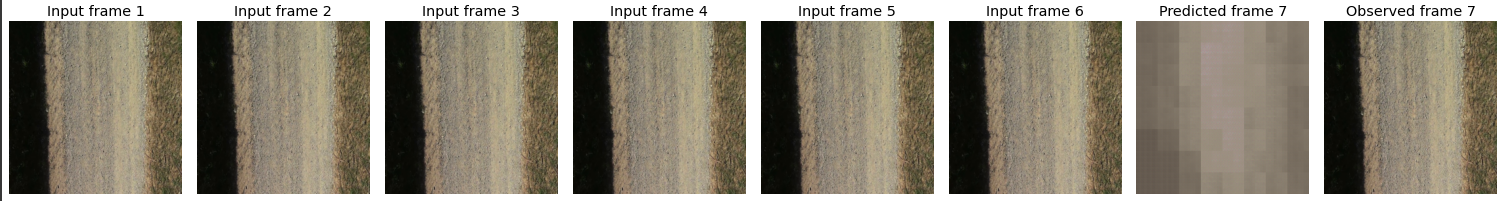

In [15]:
model_name = 'UMCD_v1.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

video_dim = (6, 3, 256, 256) # (n_frames, n_channels, frame_height, frame_width)
patch_dim = (3, 16, 16) # (n_frames, patch_height, patch_width)

embedding_dim = 64
mlp_dim = 256
n_attention_heads = 2
n_transformer_layers = 1
must_match = (8, 8)

encoder = SpatioTemporal_Encoder(video_dim=video_dim, patch_dim=patch_dim, embedding_dim=embedding_dim, mlp_dim=mlp_dim, n_attention_heads=n_attention_heads, n_transformer_layers=n_transformer_layers).to(device)
decoder = SpatioTemporal_Decoder(embedding_dim=embedding_dim, must_match=must_match).to(device)
model = SpatioTemporal_AE(encoder, decoder).to(device)


print('-'*20,model_name,'-'*20)
print(f'Model parameters:\nVideo dimension:{video_dim}, Patch dimension:{patch_dim}\nEmbedding dimension:{embedding_dim}, MLP dimension:{mlp_dim}, Number of attention heads:{n_attention_heads}, Number of transformer layers:{n_transformer_layers}\n')
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
trainable_params = sum([np.prod(p.size()) for p in trainable_params])
print(f'Trainable params: {trainable_params:_}\n')
sample_input = torch.rand(7, 6, 3, 256, 256).to(device)
sample_output = model(sample_input)
print(f'Sample input shape: {sample_input.shape}\nSample output shape: {sample_output.shape}')
print(f'Sample output values ranging from {torch.min(sample_output).item():.5f} to {torch.max(sample_output).item():.5f}\n')

try:
  model_weights = 'UMCD_v1.pth'
  weights_path = '/content/drive/MyDrive/Andreas Olsson/Public-Safety/models/' + model_weights
  model.load_state_dict(torch.load(weights_path, map_location=torch.device(device)), strict=False)
  print('Pretrained weights loaded sucessfully\n')
except:
  print('Could not load pretrained weights\n')

torch.cuda.empty_cache()

-------------------- UMCD_v1.pth --------------------
Model parameters:
Video dimension:(6, 3, 256, 256), Patch dimension:(3, 16, 16)
Embedding dimension:64, MLP dimension:256, Number of attention heads:2, Number of transformer layers:1

Trainable params: 301_427

Sample input shape: torch.Size([7, 6, 3, 256, 256])
Sample output shape: torch.Size([7, 1, 3, 256, 256])
Sample output values ranging from 0.00021 to 1.00000

Pretrained weights loaded sucessfully



## Train model (training parameters)

In [252]:
lr = 5e-3
epochs = 3

optim = optimizer.Adam(model.parameters(), lr=lr)
optim = optimizer.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = nn.BCELoss()

train_epochs(epochs, previous_min=0.6790)

--------------------Training model UMCD_v1.pth for 3 epochs with 301_427 trainable params and learning rate of 0.005--------------------



Testing Epoch [1 ---> 3]: 100%|██████████| 4/4 [01:57<00:00, 29.29s/it]


[Epoch 1]	Train loss: 0.6788	Test loss 0.6788
Test loss decreased (0.6790--->0.6788)	Saving the model...



Testing Epoch [2 ---> 3]: 100%|██████████| 4/4 [01:56<00:00, 29.13s/it]


[Epoch 2]	Train loss: 0.6789	Test loss 0.6786
Test loss decreased (0.6788--->0.6786)	Saving the model...



Testing Epoch [3 ---> 3]: 100%|██████████| 4/4 [01:55<00:00, 28.93s/it]

[Epoch 3]	Train loss: 0.6791	Test loss 0.6786
Test loss decreased (0.6786--->0.6786)	Saving the model...



In [225]:
lr = 5e-3
epochs = 3

optim = optimizer.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()

train_epochs(epochs)

--------------------Training model UMCD_v2.pth for 3 epochs with 2_301_738 trainable params and learning rate of 0.005--------------------



Testing Epoch [1 ---> 3]: 100%|██████████| 2/2 [00:45<00:00, 22.70s/it]


[Epoch 1]	Train loss: 0.6945	Test loss 0.6939
Test loss decreased (inf--->0.6939)	Saving the model...



Testing Epoch [2 ---> 3]: 100%|██████████| 2/2 [00:44<00:00, 22.50s/it]


[Epoch 2]	Train loss: 0.6944	Test loss 0.6934
Test loss decreased (0.6939--->0.6934)	Saving the model...



Testing Epoch [3 ---> 3]: 100%|██████████| 2/2 [00:45<00:00, 22.53s/it]

[Epoch 3]	Train loss: 0.6939	Test loss 0.6932
Test loss decreased (0.6934--->0.6932)	Saving the model...



# Results

In [ ]:
def evaluate_model():
  criterion = nn.BCELoss()
  print(f'{"-"*20}Testing model {model_name}{"-"*20}\n')
  with torch.no_grad():
    test_epoch_loss = 0
    model.eval()
    for batch in tqdm(test_dl, desc=f'Testing', position=0, leave=True):
      x, y = batch
      x, y = x.to(device), y.to(device)
      y_hat = model(x)

      test_loss = criterion(y_hat, y)
      test_epoch_loss += test_loss.detach().cpu().item() / len(test_dl)

    print(f' ---> Test loss: {test_epoch_loss:.4f}')

# evaluate_model()

--------------------Testing model SpatioTemporal_VisionTransformer_AutoEncoder_v3.pth--------------------



Testing: 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]

 ---> Test loss: 0.2378


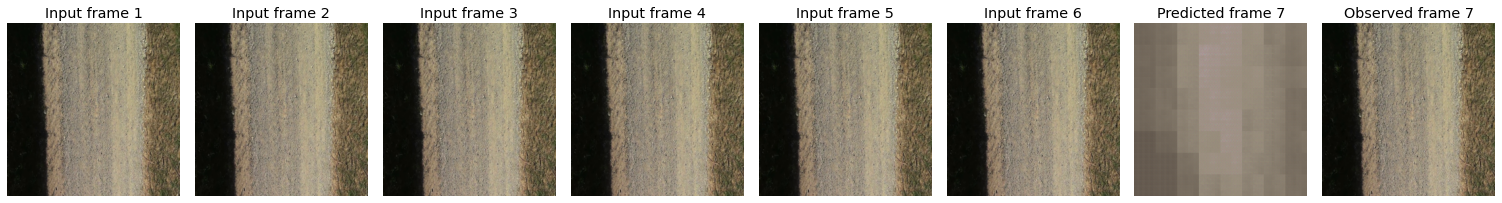

In [35]:
def show_preds(n=1):
  """Hardcoded for 6 input frames and 1 target frame (at the moment)"""
  for _ in range(n):
    f, axs = plt.subplots(1, 8, figsize=(21, 3))

    data = random.choice(test_dl.dataset)
    input = data[0].to(device)
    target = data[1].to(device)
    pred = model(input.unsqueeze(0).to(device))

    for i, img in enumerate(input): 
      axs[i].imshow(cv2.cvtColor(img.cpu().numpy().transpose(1,2,0), cv2.COLOR_BGR2RGB))
      axs[i].set_title(f'Input frame {i+1}')
      axs[i].axis('off')

    img = pred[0]
    axs[6].imshow(cv2.cvtColor(img.squeeze().detach().cpu().numpy().transpose(1,2,0), cv2.COLOR_BGR2RGB))
    axs[6].set_title(f'Predicted frame {7}')
    axs[6].axis('off')

    img = target[0]
    axs[7].imshow(cv2.cvtColor(img.squeeze().detach().cpu().numpy().transpose(1,2,0), cv2.COLOR_BGR2RGB))
    axs[7].set_title(f'Observed frame {7}')
    axs[7].axis('off')
    

    plt.tight_layout()
    plt.show()

show_preds()